# Chess Board
In this notebook, we try to build a model of the protein at the right granularity. To do this, we need to define a fragmentation that remains pure across the different snapshots. 

In [1]:
from os.path import join
from futile.Utils import ensure_dir
outdir = "serialized"
cache = "temp"
ensure_dir(cache)

False

Read in the structures.

In [2]:
from pickle import load
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)

In [3]:
from multiprocessing import Pool
from pickle import load, dump
import time
from BigDFT import BioQM
from BigDFT.Systems import System
from os.path import join
from os.path import exists

# Read in the data
pname = "updated-data.pickle"
with open(pname, "rb") as ifile:
    data = load(ifile)
    

# Fill in this routine with all of the loading you want to do
def read(geom):
    cname = join(cache, geom + ".pickle")

    try:
        with open(cname, "rb") as ifile:
            sys = load(ifile)
    except:
        fname = join(outdir, geom + "-XTB-1.1.tar.bz2")
        options = dict(sequence_from_fragments=True, disable_warnings=True)
        sys = BioQM.load(fname, options=options)
        energies = sys.interactions
        purities = sys.purities
        bond_orders = sys.bond_orders
        
        for attr in ["_atomic_purities", "_atomic_BO", "_atomic_interactions"]:
            if hasattr(sys, attr):
                delattr(sys, attr)
        
        with open(cname, "wb") as ofile:
            dump(sys, ofile)
        
    return geom, sys

# Set the number of threads yourself
numthreads = 3
p = Pool(numthreads)

# Actual call 
geoms = data["Crystal ID"][:]
systems = {}
start = time.time()
# res = p.map(read, geoms)
res = []
for g in geoms:
    print(g)
    res.append(read(g))
end = time.time()
print(end - start)

# Unpack results into this dictionary
for val in res:
    g = val[0]
    systems[g] = val[1]

Mpro-x0072
Mpro-x0104
Mpro-x0107
Mpro-x0161
Mpro-x0195
Mpro-x0305
Mpro-x0354
Mpro-x0387
Mpro-x0395
Mpro-x0397
Mpro-x0426
Mpro-x0434
Mpro-x0540
Mpro-x0678
Mpro-x0874
Mpro-x0946
Mpro-x0967
Mpro-x0991
Mpro-x0995
Mpro-x1077
Mpro-x1093
Mpro-x1249
Mpro-x0689
Mpro-x0691
Mpro-x0692
Mpro-x0705
Mpro-x0708
Mpro-x0731
Mpro-x0734
Mpro-x0736
Mpro-x0749
Mpro-x0752
Mpro-x0755
Mpro-x0759
Mpro-x0769
Mpro-x0770
Mpro-x0771
Mpro-x0774
Mpro-x0786
Mpro-x0820
Mpro-x0830
Mpro-x0831
Mpro-x0978
Mpro-x0981
Mpro-x1308
Mpro-x1311
Mpro-x1334
Mpro-x1336
Mpro-x1348
Mpro-x1351
Mpro-x1358
Mpro-x1374
Mpro-x1375
Mpro-x1380
Mpro-x1382
Mpro-x1384
Mpro-x1385
Mpro-x1386
Mpro-x1392
Mpro-x1402
Mpro-x1412
Mpro-x1418
Mpro-x1425
Mpro-x1458
Mpro-x1478
Mpro-x1493
Mpro-x0887
Mpro-x1187
Mpro-x1012
Mpro-x0390
Mpro-x0464
Mpro-x0425
Mpro-x0398
Mpro-x0669
Mpro-x1163
Mpro-x0478
Mpro-x0177
Mpro-x0194
Mpro-x1226
Mpro-x1235
Mpro-x0350
Mpro-x1002
Mpro-x1132
Mpro-x1237
Mpro-x0499
Mpro-x1119
Mpro-x0376
Mpro-x0165
Mpro-x0336
Mpro-x1086
Mpro-x1101

First, let's analyze this data so we can understand the broad trends in variance in purity across samples.

In [4]:
from BigDFT.Systems import GetFragTuple

mindict = {}
maxlookup = {}
maxdict = {}
avgdict = {}
count = {}

for g in geoms:
    for fragid, pv in systems[g].purities.items():
        pv = abs(pv)
        if "LIG" in fragid or "FRA" in fragid:
            continue
            
        if fragid not in mindict:
            mindict[fragid] = pv
        elif mindict[fragid] > pv:
            mindict[fragid] = pv
        
        if fragid not in maxdict:
            maxdict[fragid] = pv
            maxlookup[fragid] = g
        elif maxdict[fragid] < pv:
            maxdict[fragid] = pv
            maxlookup[fragid] = g
            
        if fragid not in avgdict:
            avgdict[fragid] = pv
            count[fragid] = 1
        else:
            avgdict[fragid] += pv
            count[fragid] += 1
            
for fragid in avgdict:
    avgdict[fragid] /= count[fragid]
    
deviation = {}
for fragid in mindict:
    deviation[fragid] = abs(mindict[fragid] - maxdict[fragid])

order = sorted(mindict, key=avgdict.get)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


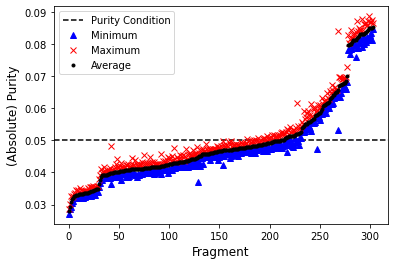

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.axhline(0.05, color='k', linestyle='--', label="Purity Condition")
axs.plot([mindict[x] for x in order], 'b^', label="Minimum")
axs.plot([maxdict[x] for x in order], 'rx', label="Maximum")
axs.plot([avgdict[x] for x in order], 'k.', label="Average")
axs.set_xlabel("Fragment", fontsize=12)
axs.set_ylabel("(Absolute) Purity", fontsize=12)
axs.legend()
plt.savefig(join("pictures", "pdeviation.eps"))

In [6]:
distribution = {x: maxdict[x] - mindict[x] for x in maxdict}
for fragid in sorted(distribution, key=distribution.get, reverse=True):
    if abs(distribution[fragid]) > 0.005:
        print(fragid, distribution[fragid], maxlookup[fragid])

A-CYS:145 0.030615910129419152 Mpro-x1308
A-SER:301 0.012200494707174617 Mpro-x0434
A-THR:225 0.011972412663658706 Mpro-x1336
A-THR:304 0.011893814404302025 Mpro-x0195
A-VAL:303 0.008735230075572725 Mpro-x1478
A-GLY:71 0.008610979501187638 Mpro-x0387
A-CYS:44 0.00853170665945139 Mpro-x1334
A-GLY:2 0.008355049163353667 Mpro-x0177
A-GLY:183 0.007986584399953103 Mpro-x1235
A-GLU:166 0.0075586504088058296 Mpro-x1093
A-ASP:48 0.007251169942995878 Mpro-x0731
A-GLY:143 0.007217826673383401 Mpro-x0387
A-CYS:265 0.0066226931321647226 Mpro-x0669
A-ALA:173 0.006281809023401988 Mpro-x1101-1
A-GLY:109 0.00623623038297029 Mpro-x0376
A-ALA:70 0.0062319516997089985 Mpro-x0464
A-GLY:179 0.0062011308465882015 Mpro-x1101-0
A-MET:49 0.006137185984243156 Mpro-x1351
A-MET:162 0.00596992378003975 Mpro-x0736
A-ALA:7 0.005947849247161442 Mpro-x1132
A-GLY:138 0.005889023842875291 Mpro-x0887
A-GLU:270 0.0058817560171604485 Mpro-x1493
A-GLY:215 0.005879462232056848 Mpro-x0734
A-GLY:120 0.005794907097163349 Mpro-x

Now we can move to auto fragmentation.

In [7]:
from BigDFT.PostProcessing import BigDFTool
btool = BigDFTool()

In [8]:
def get_target(purities):
    mindict = {}
    for g in purities:
        mindict[g] = min(purities[g].values())
    target = min(mindict, key=mindict.get)
    return target, min(purities[target].values())

In [9]:
tail = ["A-GLY:302", "A-VAL:303", "A-THR:304"]

In [10]:
from copy import deepcopy
from BigDFT.Systems import System

resys = {}
purities = {}
bond_orders = {}

for g in data["Crystal ID"][:]:
    resys[g] = System(systems[g])
    purities[g] = deepcopy(systems[g].purities)
    bond_orders[g] = deepcopy(systems[g].bond_orders)

    # Remove the ligands
    fraglist = deepcopy(list(resys[g].keys()))
    for fragid in fraglist:
        if "FRA" in fragid or "LIG" in fragid or  fragid in tail:
            del resys[g][fragid]
            del purities[g][fragid]
            del bond_orders[g][fragid]
    
    for f1 in bond_orders[g]:
        fraglist = deepcopy(list(bond_orders[g][f1]))
        for f2 in fraglist:
            if "FRA" in f2 or "LIG" in f2 or f2 in tail:
                del bond_orders[g][f1][f2]

In [11]:
target, minval = get_target(purities)

In [12]:
charges = {x: sum([z.nel for z in y]) for x, y in resys[target].items()}

In [13]:
from BigDFT.Fragments import Fragment

target, minval = get_target(purities)

while (abs(minval) > 0.05):
    print("Current worst purity value", minval, target)
    autofrag = btool.auto_fragment(resys[target], purities[target], bond_orders[target], 0.05)
    
    # Create the mapping
    mapping = {}
    for fragid in autofrag:
        mapping[fragid.replace("+","#")] = [x for x in fragid.split("+")]
        
    # Update the other systems
    for g in data["Crystal ID"][:]:
        charges = {x: sum([z.nel for z in y]) for x, y in resys[g].items()}
        new_pv, new_bo = btool.update_purity_and_bo(mapping, purities[g], bond_orders[g], charges)

        new_sys = System()
        for f1, fraglist in mapping.items():
            new_sys[f1] = Fragment()
            for f2 in fraglist:
                new_sys[f1] += resys[g][f2]

        resys[g] = new_sys
        purities[g] = new_pv
        bond_orders[g] = new_bo
    
    target, minval = get_target(purities)

Current worst purity value -0.08858190720233974 Mpro-x0387
Current worst purity value -0.05353204603556079 Mpro-x0731
Current worst purity value -0.05227877682142599 Mpro-x1374
Current worst purity value -0.051511988386888745 Mpro-x0395
Current worst purity value -0.051411330738778384 Mpro-x0354
Current worst purity value -0.05105204697579718 Mpro-x1163
Current worst purity value -0.050680411008359266 Mpro-x0752
Current worst purity value -0.05055960191492771 Mpro-x0540
Current worst purity value -0.05055134169467742 Mpro-x0831
Current worst purity value -0.05032820945976135 Mpro-x1101-1
Current worst purity value -0.050090332177578904 Mpro-x0769
Current worst purity value -0.050069299668078486 Mpro-x1119


In [14]:
mindict = {}
maxdict = {}
maxlookup = {}
avgdict = {}
count = {}

for sys in data["Crystal ID"][:]:
    for fragid, pv in purities[sys].items():
        pv = abs(pv)
        if fragid not in mindict:
            mindict[fragid] = pv
        elif mindict[fragid] > pv:
            mindict[fragid] = pv
        
        if fragid not in maxdict:
            maxdict[fragid] = pv
            maxlookup[fragid] = sys
        elif maxdict[fragid] < pv:
            maxdict[fragid] = pv
            maxlookup[fragid] = sys
            
        if fragid not in avgdict:
            avgdict[fragid] = pv
            count[fragid] = 1
        else:
            avgdict[fragid] += pv
            count[fragid] += 1
            
for fragid in avgdict:
    avgdict[fragid] /= count[fragid]
    
deviation = {}
for fragid in mindict:
    deviation[fragid] = abs(mindict[fragid] - maxdict[fragid])

order = sorted(mindict, key=avgdict.get)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


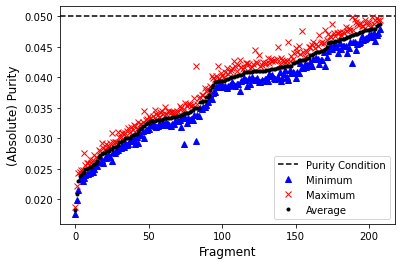

In [15]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(6,4))
axs.axhline(0.05, color='k', linestyle='--', label="Purity Condition")
axs.plot([mindict[x] for x in order], 'b^', label="Minimum")
axs.plot([maxdict[x] for x in order], 'rx', label="Maximum")
axs.plot([avgdict[x] for x in order], 'k.', label="Average")
axs.set_xlabel("Fragment", fontsize=12)
axs.set_ylabel("(Absolute) Purity", fontsize=12)
axs.legend()
plt.savefig(join("pictures", "pdeviation.eps"))

In [16]:
distribution = {x: maxdict[x] - mindict[x] for x in maxdict}
for fragid, d in distribution.items():
    if abs(d) > 0.005:
        print(fragid, d, maxlookup[fragid])

A-MET:49 0.006137185984243149 Mpro-x1351
A-CYS:145#A-GLY:143#A-SER:144 0.012294142449482355 Mpro-x1308
A-MET:162 0.00596992378003975 Mpro-x0736
A-GLU:166 0.007558650408805823 Mpro-x1093
A-MET:235 0.005016914927846235 Mpro-x0991
A-GLU:270 0.0058817560171604485 Mpro-x1493
A-SER:301#A-CYS:300 0.005719487512443718 Mpro-x0195


In [17]:
biosys = BioQM.load(join(outdir, data["Crystal ID"][0] + "-XTB-1.1.tar.bz2"),
                    options=dict(sequence_from_fragments=True, disable_warnings=True))

In [18]:
colorlist = []
# for f1 in biosys.fragment_names:
for f1 in biosys.keys():
    for f2 in purities[data["Crystal ID"][0] ]:
        if f1 in f2:
            colorlist.append(distribution[f2])
            break

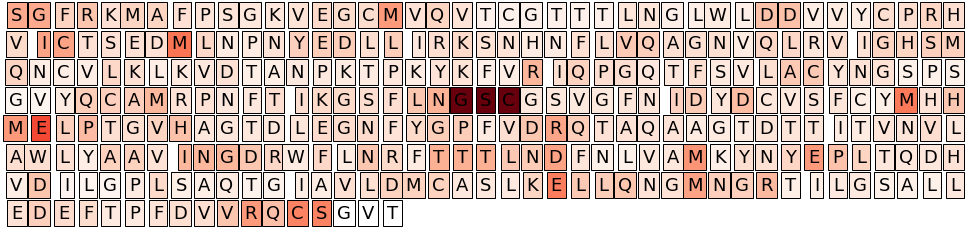

In [19]:
biosys.display_sequences(field_vals=colorlist)

## Strongest Interactors
Now we try to investigate the strongest interacting fragments. 

In [20]:
strengths = {}
full_strengths = {}
for g in geoms:
    full_strengths[g] = 0.0
    for fid1, f1 in systems[g].interactions.items():
        if "FRA" not in fid1 and "LIG" not in fid1:
            continue
        temp = 0.0
        for fid2, f2 in f1.items():
            if "FRA" in fid2 or "LIG" in fid2:
                continue
            temp += f2
        if abs(temp) > 0.05:
            strengths[(g,fid1)] = temp
        full_strengths[g] += temp

First summarize the total interaction strength.

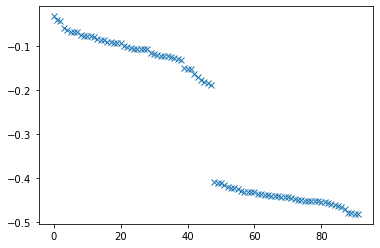

In [21]:
fig, axs = plt.subplots(1,1)
axs.plot(sorted(full_strengths.values(), reverse=True), 'x')

Text(0, 0.5, 'Interaction Strength')

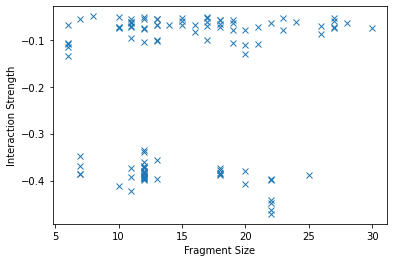

In [22]:
fig, axs = plt.subplots(1,1)
sizes = [len(systems[x[0]][x[1]]) for x in strengths]
values = list(strengths.values())

axs.plot(sizes, values, 'x')
axs.set_xlabel("Fragment Size")
axs.set_ylabel("Interaction Strength")

In [23]:
from os import system
from BigDFT.IO import write_pdb

smiles = {}
for g, f1 in strengths:
    name = str(g) + "-" + f1
    oname1 = join(cache, name+"-strongest.pdb")
    oname2 = join(cache, name+"-strongest.smiles")
    
    sys = System()
    sys[f1] = systems[g][f1]
    
    with open(oname1, "w") as ofile:
        write_pdb(sys, ofile)
    
    system("obabel -ipdb " + oname1 + " -ocan > " + oname2)
    
    with open(oname2) as ifile:
        smiles[(g, f1)] = next(ifile).split()[0]

In [24]:
covalent_lookup = {}
for g, c in zip(data["Crystal ID"], data["Site"]):
    covalent_lookup[g] = "cov" in c

for g, f1 in sorted(strengths, key=strengths.get, reverse=False):
#     if covalent_lookup[g]:
        print(g, f1, smiles[(g,f1)], strengths[(g,f1)], covalent_lookup[g])

Mpro-x0731 A-LIG:305 OS(N1CCN(CC1)C(=O)C)O -0.4708739555849365 True
Mpro-x0691 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.4618692302722154 True
Mpro-x0769 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.4483691139121299 True
Mpro-x1336 A-LIG:305 OS(N1CCN(CC1)C(=O)C)O -0.4407767246297145 True
Mpro-x0708 A-LIG:305 O=CNNC(=O)C -0.4213614961974834 True
Mpro-x0752 A-LIG:306 CNC(=O)C -0.4116628527137513 True
Mpro-x1375 A-LIG:305 CC(=O)N[C@@H]1CCS(=O)(=O)C1 -0.4069038124852839 True
Mpro-x0771 A-LIG:306 OS(N1CCN(CC1)C(=O)C)O -0.3984779041577044 True
Mpro-x1493 A-LIG:306 CC(=O)N(C)C -0.39843686349287677 True
Mpro-x0820 A-LIG:306 CCNC(=O)C -0.3961975698172323 True
Mpro-x0734 A-LIG:307 CC(=O)N(C)C -0.39578959220995047 True
Mpro-x1418 A-LIG:306 CN1CCN(CC1)C(=O)C -0.3954829304365555 True
Mpro-x0759 A-LIG:305 CC(=O)N(C)C -0.3945419570436842 True
Mpro-x0755 A-LIG:307 CC(=O)N(C)C -0.39376456768415613 True
Mpro-x0692 A-LIG:306 CC(=O)N(C)C -0.39334362460409944 True
Mpro-x0689 A-LIG:305 CC(=O)N(C)C -0.39209056672473747 True
